Iter 0: Loss = 47.61602005
Iter 10: Loss = 47.61600878
Iter 20: Loss = 47.61600768
Iter 30: Loss = 47.61600757
Iter 40: Loss = 47.61600755
Iter 50: Loss = 47.61600755
Iter 60: Loss = 47.61600755
Iter 70: Loss = 47.61600755
Iter 80: Loss = 47.61600755
Iter 90: Loss = 47.61600755


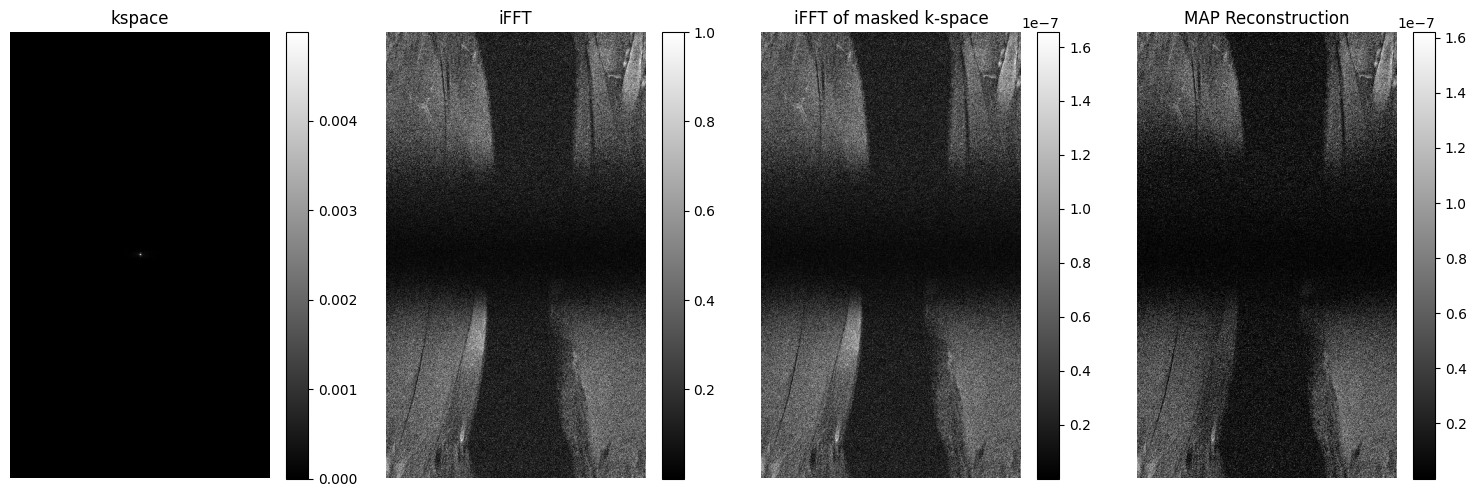

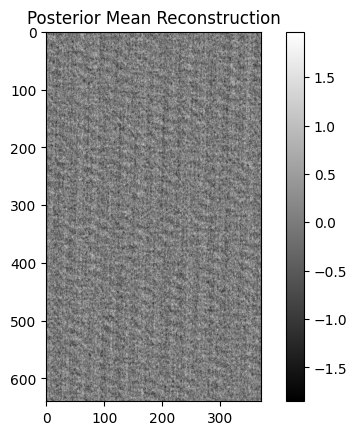

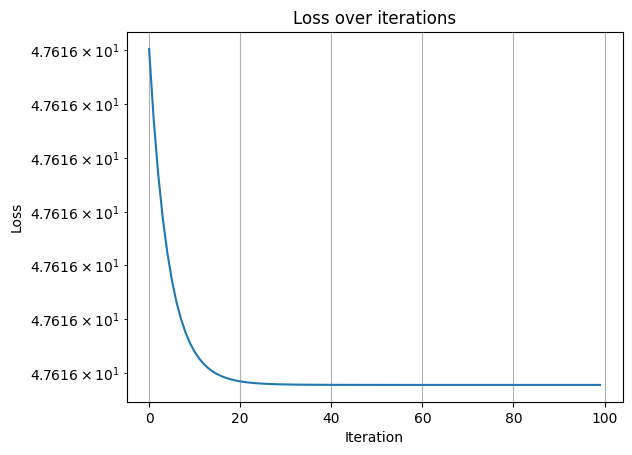

" plt.imshow(posterior_mean, cmap='gray')\nplt.title('Posterior Mean Reconstruction')\nplt.colorbar()\nplt.show() "

In [5]:
import os
import sys

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from MAP.masks import (
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
)
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data import SliceDataset
from data.load_knee_mri import load_fastmri_data

train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

sample = val_dataset[1189]
# sample = val_dataset[0]
kspace = sample[0]  # complex64, shape (H, W)
target = sample[1]  # real-valued ground truth (optional)

# kspace, target, attrs, fname, slice_idx, max_value = sample

# Zero-filled reconstruction: apply inverse FFT
reconstructed = np.fft.ifft2(kspace)
image_abs = np.abs(reconstructed)

# Normalize to [0, 1] for visualization
image_abs /= np.max(image_abs)

# for i, item in enumerate(sample):
#    print(f"Sample[{i}] type: {type(item)}")
#    if hasattr(item, "shape"):
#        print(f"Sample[{i}] shape: {item.shape}")

#print("k-space type:", type(sample[0]), "shape:", sample[0].shape)
#print("target type:", type(sample[1]), "shape:", getattr(sample[1], "shape", None))

# mask and MAP
mask = VariableDensityMask('gaussian', 2, seed=30).generate(kspace.shape)
#mask = BernoulliMask(1, seed=30).generate(kspace.shape)
#mask = CenteredBernoulliMask(0.01, 0.25, seed=30).generate(kspace.shape)
y = mask * kspace
map_estimator = MAPEstimator(mask, 0.95, 0.01, 1e-2, 0.25, 100)
map_reconstruct = map_estimator.subgradient_descent(y)

samples = map_estimator.langevin_sampling(y, 150, 20, 3)
posterior_mean = np.mean(
    samples, axis=0
)  # Compute a point estimate (e.g., posterior mean)
posterior_std = np.std(
    samples, axis=0
)  # Estimate uncertainty (e.g., pixel-wise variance)


# Plot
"""
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.log(1 + np.abs(kspace)), cmap='gray')
plt.title("K-space (log magnitude)")
plt.axis('on')

plt.subplot(1, 3, 2)
plt.imshow(image_abs, cmap='gray')
plt.title("Zero-filled IFFT")
plt.axis('on')


plt.subplot(1, 3, 3)
if target is not None:
    plt.imshow(target, cmap='gray')
    plt.title("Ground Truth")
else:
    plt.text(0.5, 0.5, 'No target available', ha='center', va='center')
plt.axis('on')

plt.tight_layout()
plt.show()
"""

# plot MAP
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("kspace")
# plt.imshow(np.abs(np.fft.ifft2(y)), cmap='gray')
plt.imshow(np.log(1 + np.abs(kspace)), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("iFFT")
# plt.imshow(np.abs(np.fft.ifft2(y)), cmap='gray')
plt.imshow(image_abs, cmap="gray")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("iFFT of masked k-space")
plt.imshow(np.abs(np.fft.ifft2(y)), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("MAP Reconstruction")
plt.imshow(np.abs(map_reconstruct), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# langevin
plt.imshow(posterior_mean, cmap="gray")
plt.title("Posterior Mean Reconstruction")
plt.colorbar()
plt.show()

# loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

""" plt.imshow(posterior_mean, cmap='gray')
plt.title('Posterior Mean Reconstruction')
plt.colorbar()
plt.show() """